In [1]:
%pwd

'c:\\Users\\Fahmi Maulana\\Documents\\Projects\\weather-anomaly-detection\\exploratory-data-analysis\\notebooks'

In [2]:
%cd ../..

c:\Users\Fahmi Maulana\Documents\Projects\weather-anomaly-detection


c:\Users\Fahmi Maulana\.pyenv-win-venv\envs\weather-anomaly-detection\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tseries.transforms.stationary_utils import check_trend, check_seasonality
import statsmodels.api as sm

# Load Dataset

In [4]:
pd.set_option("display.max_columns", None)
data = pd.read_csv("./data/02_processed/jakarta_daily_weather_data_2010-2023_processed.csv", 
                     date_parser=lambda x: pd.to_datetime(x).tz_convert('Asia/Bangkok'),
                     parse_dates=["datetime"],
                    )
daily_precipitation = data[["datetime", "precipitation_sum"]].copy()
daily_precipitation.head()

C:\Users\Fahmi Maulana\AppData\Local\Temp\ipykernel_23744\1886673195.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv("./data/02_processed/jakarta_daily_weather_data_2010-2023_processed.csv",


datetime  precipitation_sum
0 2010-01-01 00:00:00+07:00           4.000000
1 2010-01-02 00:00:00+07:00           6.500000
2 2010-01-03 00:00:00+07:00           7.600000
3 2010-01-04 00:00:00+07:00           0.900000
4 2010-01-05 00:00:00+07:00          14.300001

## Seasonal Decompose

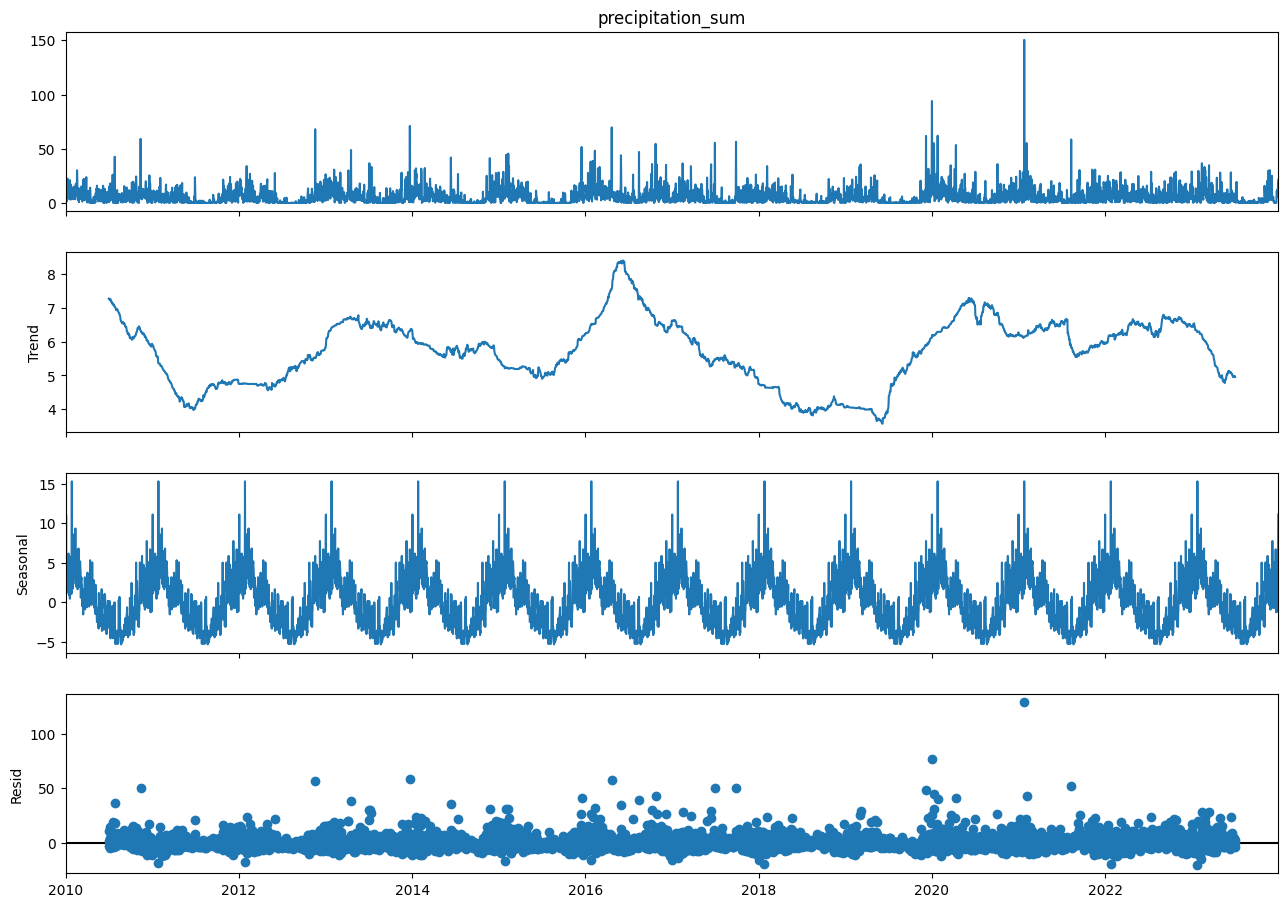

In [5]:
# Seasonal decomposition of time series data
decomposition = seasonal_decompose(daily_precipitation.set_index('datetime')['precipitation_sum'], model='additive', period=365)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

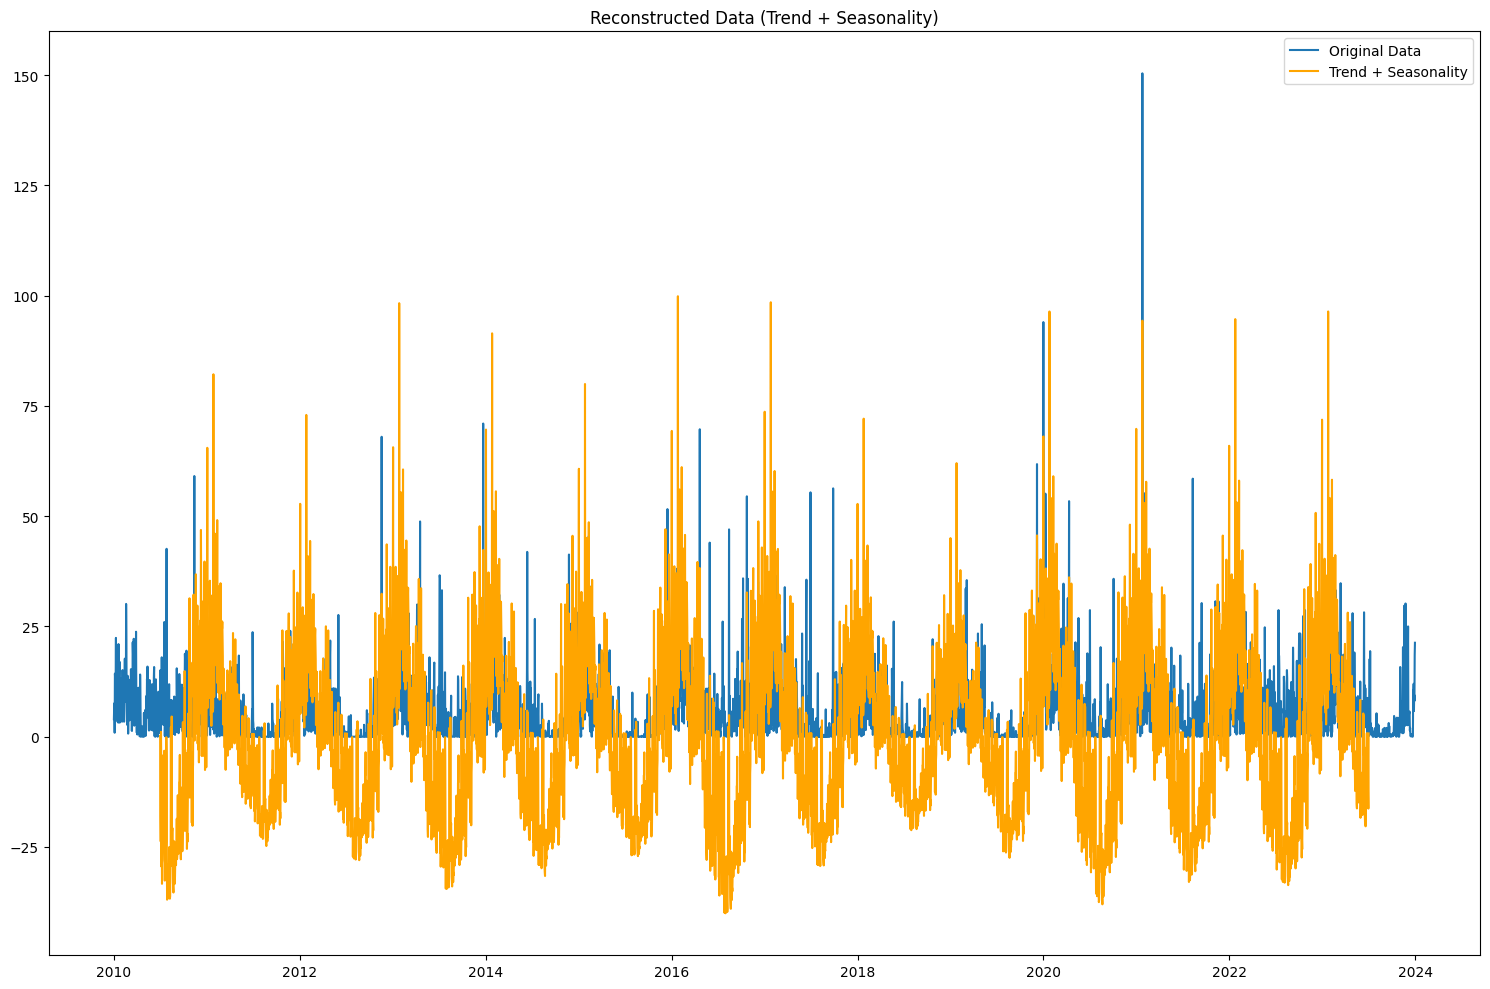

In [6]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

reconstructed = trend * seasonal

# Plot perbandingan antara data asli dengan hasil dekomposisi
plt.figure(figsize=(15, 10))

plt.plot(daily_precipitation.set_index('datetime')['precipitation_sum'], label='Original Data')
plt.plot(reconstructed, label='Trend + Seasonality', color='orange')
plt.title('Original Data')
plt.title('Reconstructed Data (Trend + Seasonality)')
plt.legend()

plt.tight_layout()
plt.show()

# Univariate Anomaly Detection
## Mean and Standard Deviation on Residual

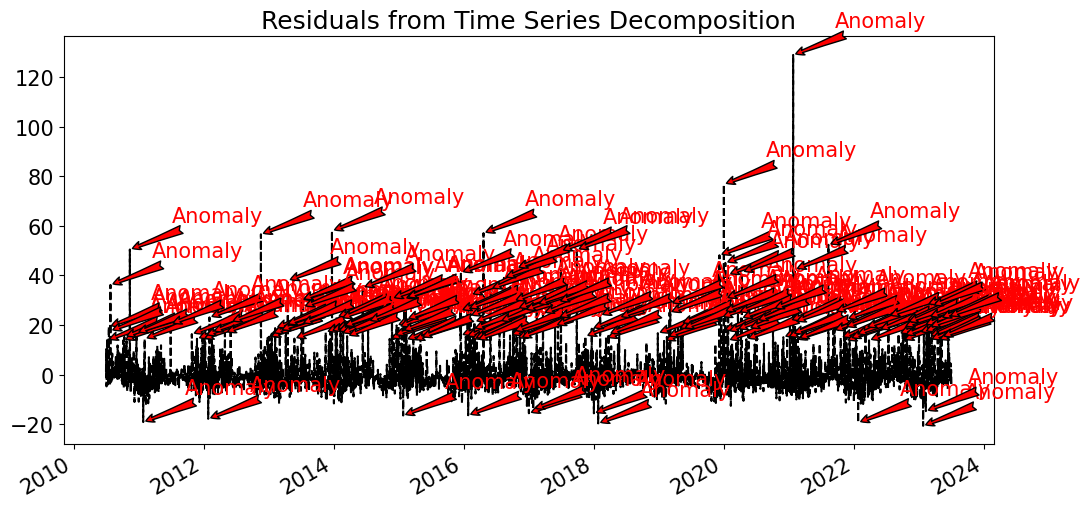

In [7]:
# Plot the residuals
plt.rc('figure', figsize=(12, 6))
plt.rc('font', size=15)
fig, ax = plt.subplots()
x = residual.index
y = residual.values
ax.plot(x, y, color='black', linestyle='--')
ax.set_title('Residuals from Time Series Decomposition')
fig.autofmt_xdate()

# Detect anomalies (e.g., residuals exceeding 2 standard deviations)
threshold = 2
residual_mean = np.mean(residual)
residual_std = np.std(residual)
anomalies = residual[np.abs(residual - residual_mean) > threshold * residual_std]

# Annotate anomalies
for idx in anomalies.index:
    ax.annotate('Anomaly', (mdates.date2num(idx), residual.loc[idx]), xytext=(30, 20),
                textcoords='offset points', color='red',
                arrowprops=dict(facecolor='red', arrowstyle='fancy'))

plt.show()

In [8]:
# Define residual, mean, and std
residual_mean = np.mean(residual)
residual_std = np.std(residual)
threshold = 2

# Detect anomalies
anomalies = residual[np.abs(residual - residual_mean) > threshold * residual_std]

daily_precipitation['anomaly_mstd_residual'] = daily_precipitation['datetime'].isin(anomalies.index)

# Create the residual plot
fig = go.Figure()

# Plot the actual values
fig.add_trace(go.Scatter(
    x=daily_precipitation.datetime, 
    y=daily_precipitation.precipitation_sum,
    mode='lines',
    name='Actual Values'
))


# Plot the residuals
fig.add_trace(go.Scatter(
    x=residual.index, 
    y=residual.values,
    mode='lines',
    line=dict(color='aqua', dash='solid'),
    name='Residuals'
))

# Annotate anomalies
for idx in anomalies.index:
    fig.add_annotation(
        x=idx,
        y=residual.loc[idx],
        text="Anomaly",
        showarrow=True,
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor='red',
        ax=30,  # x offset
        ay=20,  # y offset
        font=dict(color='red')
    )

# Update layout
fig.update_layout(
    title='Anomaly Detection in Residuals Using Mean and Standard Deviation',
    xaxis_title='Date',
    yaxis_title='Precipitation',
    font=dict(size=15),
    autosize=True,
    width=1200,
    height=600
)

# Show the figure
fig.show()

### Normality Check

In [9]:
def is_normal(test, p_level=0.05):
    stat, pval = test
    return 'Normal' if pval > 0.05 else 'Not Normal'

In [10]:
normal_args = (np.mean(residual),np.std(residual))

print(is_normal(shapiro(residual)))
print(is_normal(normaltest(residual)))
print(is_normal(normal_ad(residual)))
print(is_normal(kstest_normal(residual)))

Not Normal
Not Normal
Not Normal
Not Normal


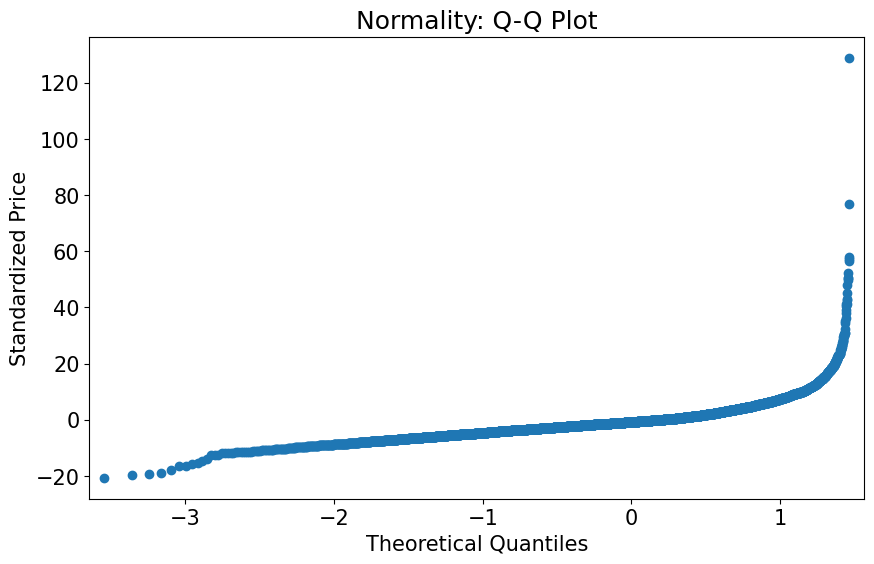

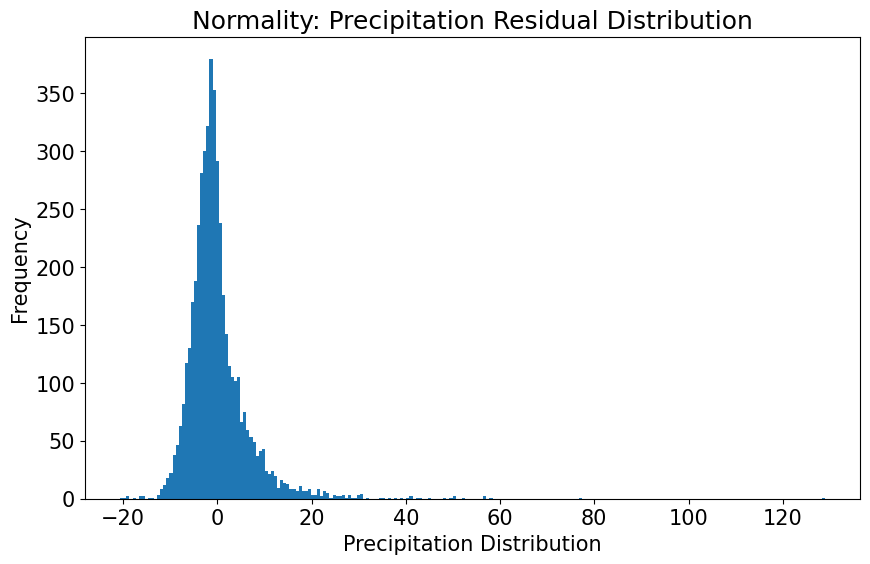

In [11]:
plt.rcParams["figure.figsize"] = [10, 6]

sm.qqplot(residual)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized Price')
plt.title('Normality: Q-Q Plot')
plt.show()

plt.hist(residual, bins='auto')
plt.xlabel('Precipitation Distribution')
plt.ylabel('Frequency')
plt.title('Normality: Precipitation Residual Distribution')
plt.show()

## Median and Median Absolute Deviation (MAD) on Residual

In [12]:
# Define residual, median, and MAD
residual_median = np.median(residual.dropna())
residual_mad = np.median(np.abs(residual.dropna() - residual_median))
threshold = 3  # Define the threshold for anomaly detection

# Detect anomalies
anomalies = residual[np.abs(residual - residual_median) > threshold * residual_mad]

daily_precipitation['anomaly_mad_residual'] = daily_precipitation['datetime'].isin(anomalies.index)

In [13]:
# Create the residual plot
fig = go.Figure()

# Plot the actual values
fig.add_trace(go.Scatter(
    x=daily_precipitation.datetime, 
    y=daily_precipitation.precipitation_sum,
    mode='lines',
    name='Actual Values'
))

# Plot the residuals
fig.add_trace(go.Scatter(
    x=residual.index, 
    y=residual.values,
    mode='lines',
    line=dict(color='aqua', dash='solid'),
    name='Residuals'
))

# Annotate anomalies
for idx in anomalies.index:
    fig.add_annotation(
        x=idx,
        y=residual.loc[idx],
        text="Anomaly",
        showarrow=True,
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor='red',
        ax=30,  # x offset
        ay=20,  # y offset
        font=dict(color='red')
    )

# Update layout
fig.update_layout(
    title='Anomaly Detection in Residuals Using Mean and Standard Deviation',
    xaxis_title='Date',
    yaxis_title='Precipitation',
    font=dict(size=15),
    autosize=True,
    width=1200,
    height=600
)

# Show the figure
fig.show()

## Rolling MAD

In [14]:
# Function to calculate rolling median
def rolling_median(x, window):
    return x.rolling(window=window, center=True).median()

# Function to calculate rolling MAD
def rolling_mad(x, window):
    rolling_med = rolling_median(x, window)
    abs_deviation = np.abs(x - rolling_med)
    return abs_deviation.rolling(window=window, center=True).median()

# Function to detect anomalies
def detect_anomalies(data, window, threshold):
    rolling_med = rolling_median(data, window)
    rolling_mad_val = rolling_mad(data, window)
    anomalies = (np.abs(data - rolling_med) > threshold * rolling_mad_val)
    return anomalies, rolling_med, rolling_mad_val

In [15]:
# # Parameters
# window = 7
# threshold = 3

# raw_df_rolling_mad = daily_precipitation.copy()


# # Detect anomalies
# raw_df_rolling_mad['anomaly'], raw_df_rolling_mad['rolling_median'], raw_df_rolling_mad['rolling_mad'] = detect_anomalies(raw_df_rolling_mad['precipitation_sum'], window, threshold)

# # Calculate the upper and lower bounds
# raw_df_rolling_mad['upper_bound'] = raw_df_rolling_mad['rolling_median'] + threshold * raw_df_rolling_mad['rolling_mad']
# raw_df_rolling_mad['lower_bound'] = np.maximum(raw_df_rolling_mad['rolling_median'] - threshold * raw_df_rolling_mad['rolling_mad'], 0)

# # Plot with Plotly
# fig = go.Figure()

# # Original data
# fig.add_trace(go.Scatter(x=raw_df_rolling_mad['datetime'], y=raw_df_rolling_mad['precipitation_sum'], mode='lines', name='Precipitation Sum'))

# # Rolling median
# fig.add_trace(go.Scatter(x=raw_df_rolling_mad['datetime'], y=raw_df_rolling_mad['rolling_median'], mode='lines', name='Rolling Median'))

# # Rolling MAD bounds
# fig.add_trace(go.Scatter(x=raw_df_rolling_mad['datetime'], y=raw_df_rolling_mad["upper_bound"], mode='lines', 
#                          line=dict(dash='dash'), name='Upper Bound'))
# fig.add_trace(go.Scatter(x=raw_df_rolling_mad['datetime'], y=raw_df_rolling_mad["lower_bound"], mode='lines', 
#                          line=dict(dash='dash'), name='Lower Bound'))

# # Anomalies
# anomalies = raw_df_rolling_mad[raw_df_rolling_mad['anomaly']]
# fig.add_trace(go.Scatter(x=anomalies['datetime'], y=anomalies['precipitation_sum'], mode='markers', 
#                          marker=dict(color='red', size=8), name='Anomalies'))

# # Update layout
# fig.update_layout(title='Precipitation Sum with Rolling MAD Anomaly Detection (7-day Rolling Window)',
#                   xaxis_title='Date',
#                   yaxis_title='Precipitation Sum',
#                   template='plotly_white')

# fig.show()

In [16]:
import plotly.graph_objs as go
import numpy as np

# Parameters
window = 7
threshold = 3

raw_df_rolling_mad = daily_precipitation.copy()

# Detect anomalies
raw_df_rolling_mad['anomaly'], raw_df_rolling_mad['rolling_median'], raw_df_rolling_mad['rolling_mad'] = detect_anomalies(raw_df_rolling_mad['precipitation_sum'], window, threshold)

# Calculate the upper and lower bounds
raw_df_rolling_mad['upper_bound'] = raw_df_rolling_mad['rolling_median'] + threshold * raw_df_rolling_mad['rolling_mad']
raw_df_rolling_mad['lower_bound'] = np.maximum(raw_df_rolling_mad['rolling_median'] - threshold * raw_df_rolling_mad['rolling_mad'], 0)

# Plot with Plotly
fig = go.Figure()

# Original data
fig.add_trace(go.Scatter(x=raw_df_rolling_mad['datetime'], y=raw_df_rolling_mad['precipitation_sum'], mode='lines', name='Precipitation Sum'))

# Rolling median
fig.add_trace(go.Scatter(x=raw_df_rolling_mad['datetime'], y=raw_df_rolling_mad['rolling_median'], mode='lines', name='Rolling Median'))

# Rolling MAD bounds with fill
fig.add_trace(go.Scatter(
    x=raw_df_rolling_mad['datetime'],
    y=raw_df_rolling_mad["upper_bound"],
    mode='lines',
    line=dict(dash='dash', color='rgba(255,0,0,0)'),
    name='Upper Bound',
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=raw_df_rolling_mad['datetime'],
    y=raw_df_rolling_mad["lower_bound"],
    mode='lines',
    line=dict(dash='dash', color='rgba(255,0,0,0)'),
    fill='tonexty',
    fillcolor='rgba(173, 216, 230, 0.3)',  # Light blue color
    name='Lower Bound'
))

# Anomalies
anomalies = raw_df_rolling_mad[raw_df_rolling_mad['anomaly']]
fig.add_trace(go.Scatter(x=anomalies['datetime'], y=anomalies['precipitation_sum'], mode='markers', 
                         marker=dict(color='red', size=8), name='Anomalies'))

# Update layout
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Precipitation Sum with Rolling MAD Anomaly Detection (7-day Rolling Window)',
                  height=600,
                  width=1000,
                  xaxis_title='Date',
                  yaxis_title='Precipitation Sum',
                  template='plotly_white')

fig.show()

## Prophet

In [17]:
from prophet import Prophet

c:\Users\Fahmi Maulana\.pyenv-win-venv\envs\weather-anomaly-detection\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [38]:
def fit_predict_model(
        dataframe: pd.DataFrame, 
        datetime_column: str,
        target_column: str,
        interval_width: float = 0.99, 
        changepoint_range: float = 0.8,
        daily_seasonality: bool = False,
        weekly_seasonality: bool = False,
        yearly_seasonality: bool = False,
        regressors: list = None
    ):
   
    dataframe = dataframe[[datetime_column, target_column] + (regressors if regressors else [])].rename(columns={datetime_column: "ds", target_column: "y"})
   
    if dataframe['ds'].dt.tz is not None:
        dataframe['ds'] = pd.to_datetime(dataframe['ds']).dt.date
   
    m = Prophet(daily_seasonality=daily_seasonality, yearly_seasonality=yearly_seasonality, weekly_seasonality=weekly_seasonality,
                seasonality_mode='additive',
                interval_width=interval_width,
                changepoint_range=changepoint_range,)
    
    if regressors:
        for regressor in regressors:
            m.add_regressor(regressor)
    
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop=True)
    return forecast

def detect_anomalies_prophet(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1
    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    forecasted['precipitation_anomaly'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'precipitation_anomaly'] = (forecasted['fact'] - forecasted['yhat_upper'])
    forecasted.loc[forecasted['anomaly'] ==-1, 'precipitation_anomaly'] = (forecasted['fact'] - forecasted['yhat_lower'])
    return forecasted

def plot_anomalies(forecasted):
    fig = go.Figure()
    
    # Actual values
    fig.add_trace(go.Scatter(x=forecasted['ds'], y=forecasted['fact'], 
                             mode='lines', name='Actual', 
                             line=dict(color='blue')))
    
    # Forecasted values
    fig.add_trace(go.Scatter(x=forecasted['ds'], y=forecasted['yhat'], 
                             mode='lines', name='Forecast', 
                             line=dict(color='green')))
    
    # Upper and lower bounds
    fig.add_trace(go.Scatter(x=forecasted['ds'], y=forecasted['yhat_upper'], 
                             mode='lines', name='Upper Bound', 
                             line=dict(color='rgba(0,100,80,0.2)')))
    fig.add_trace(go.Scatter(x=forecasted['ds'], y=forecasted['yhat_lower'], 
                             mode='lines', name='Lower Bound', 
                             line=dict(color='rgba(0,100,80,0.2)'),
                             fill='tonexty'))

    # Anomalies
    anomalies = forecasted[forecasted['anomaly'] != 0]
    fig.add_trace(go.Scatter(x=anomalies['ds'], y=anomalies['fact'], 
                             mode='markers', name='Anomalies',
                             marker=dict(color='red', size=8)))
    
    fig.update_xaxes(rangeslider_visible=True)
    fig.update_layout(title='Time Series with Anomalies',
                      xaxis_title='Date',
                      yaxis_title='Values',
                      template='plotly_white')
    
    fig.show()

In [39]:
forecast_df = fit_predict_model(daily_precipitation, datetime_column='datetime', target_column="precipitation_sum", yearly_seasonality=True, interval_width=0.7)
anomalies1 = detect_anomalies_prophet(forecast_df)
plot_anomalies(anomalies1)

12:54:20 - cmdstanpy - INFO - Chain [1] start processing
12:54:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Fahmi Maulana\AppData\Local\Temp\ipykernel_23744\3921834582.py:39: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.36639428e-01 1.47715118e-01 3.99785817e-01 1.64058367e-01
 2.54202874e-02 3.07717965e-01 1.91568279e-01 3.27553944e-01
 3.86583854e-01 3.76247255e-02 2.10283051e-01 6.80958077e-03
 7.65201200e-02 1.57441435e-02 1.30300706e-01 2.24217669e-01
 6.41163340e-02 2.75001635e-01 3.56785887e-01 2.59626759e-01
 6.21708724e-01 6.06524447e-01 7.69052687e-01 2.28268146e-01
 4.21198116e-01 2.00473040e-01 2.95623131e-01 2.03430278e-01
 3.22351827e-03 4.24987252e-02 4.58655010e-02 9.74828394e-02
 3.94153417e-01 3.35795558e-01 4.32741412e-01 2.94603159e-01
 1.86390058e-01 5.10363533e-01 3.04786507e-01 3.51267585e-02
 6.00349343e-02 6.61308346e-02 7.56475331e-01 2.86933259e-02
 2.5985804

## Monthly-based Percentile

In [20]:
# Extract month and year from datetime
daily_precipitation['month'] = daily_precipitation['datetime'].dt.month
daily_precipitation['year'] = daily_precipitation['datetime'].dt.year

# Calculate monthly bounds using percentiles
monthly_data = daily_precipitation.groupby(['year', 'month'])['precipitation_sum'].sum().reset_index()

bounds = {}
for month in range(1, 13):
    monthly_precip = monthly_data[monthly_data['month'] == month]['precipitation_sum']
    if month in [4, 5, 6, 7, 8, 9]:  # Bulan musim kemarau
        lower_bound = 0  # Menetapkan batas bawah tetap 0 untuk musim kemarau
    else:  # Bulan musim hujan
        lower_bound = np.percentile(monthly_precip, 5)
    upper_bound = np.percentile(monthly_precip, 95)
    bounds[month] = (lower_bound, upper_bound)

# Detect anomalies
daily_precipitation['Lower_Bound'] = daily_precipitation['month'].map(lambda x: bounds[x][0] / 30)
daily_precipitation['Upper_Bound'] = daily_precipitation['month'].map(lambda x: bounds[x][1] / 30)

# Combine both anomaly detections
daily_precipitation['Percentile_Anomaly'] = (daily_precipitation['precipitation_sum'] < daily_precipitation['Lower_Bound']) | (daily_precipitation['precipitation_sum'] > daily_precipitation['Upper_Bound'])

# View anomalies
anomalies = daily_precipitation[daily_precipitation['Percentile_Anomaly']]

# Plot the results using Plotly
fig = go.Figure()

# Add the daily precipitation_sum data
fig.add_trace(go.Scatter(
    x=daily_precipitation['datetime'], y=daily_precipitation['precipitation_sum'],
    mode='lines', name='Daily precipitation_sum',
    line=dict(color='blue', width=1)
))

# Add the anomalies
fig.add_trace(go.Scatter(
    x=anomalies['datetime'], y=anomalies['precipitation_sum'],
    mode='markers', name='Anomalies',
    marker=dict(color='red', size=5)
))

# Add the bounds with fill
fig.add_trace(go.Scatter(
    x=daily_precipitation['datetime'], y=daily_precipitation['Upper_Bound'],
    mode='lines',
    line=dict(dash='dash', color='rgba(0,255,0,0)'),
    name='Upper Bound',
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=daily_precipitation['datetime'],
    y=daily_precipitation['Lower_Bound'],
    mode='lines',
    line=dict(dash='dash', color='rgba(0,255,0,0)'),
    fill='tonexty',
    fillcolor='rgba(173, 216, 230, 0.3)',  # Light blue color
    name='Lower Bound'
))

# Update layout
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    title='Daily precipitation_sum with Anomaly Detection',
    width=1000,
    height=600,
    xaxis_title='Date',
    yaxis_title='precipitation_sum',
    showlegend=True,
    template="plotly_white"
)

fig.show()

## Monthly-based Percentile with Climate Variability Data

In [21]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go

# Data El Niño, La Niña, dan tahun netral
el_nino_years = [2014, 2015, 2018, 2023]
la_nina_years = [2010, 2011, 2016, 2020, 2021, 2022]
# neutral_years = [2001, 2002, 2003, 2004]

# Fungsi untuk menentukan jenis tahun
def classify_year(year):
    if year in el_nino_years:
        return 'El Nino'
    elif year in la_nina_years:
        return 'La Nina'
    else:
        return 'Neutral'

# Mengelompokkan data berdasarkan tahun
daily_precipitation['year_type'] = daily_precipitation['year'].apply(classify_year)

# Fungsi untuk mengklasifikasikan musim berdasarkan jenis tahun
def classify_season(month, year_type):
    if year_type == 'El Nino':
        if month in [1, 2]:
            return 'Peak Rainy Season'
        elif month == 4:
            return 'Transition Rainy to Dry'
        elif 5 <= month <= 10:
            return 'Dry Season'
        elif month in [7, 8]:
            return 'Peak Dry Season'
        elif month == 11:
            return 'Transition Dry to Rainy'
        else:
            return 'Rainy Season'
    elif year_type == 'La Nina':
        if month in [1, 2]:
            return 'Peak Rainy Season'
        elif month == 5:
            return 'Transition Rainy to Dry'
        elif 6 <= month <= 8:
            return 'Dry Season'
        elif month in [7, 8]:
            return 'Peak Dry Season'
        elif month == 9:
            return 'Transition Dry to Rainy'
        else:
            return 'Rainy Season'
    else:  # Neutral
        if month in [1, 2]:
            return 'Peak Rainy Season'
        elif month == 4:
            return 'Transition Rainy to Dry'
        elif 5 <= month <= 9:
            return 'Dry Season'
        elif month in [7, 8]:
            return 'Peak Dry Season'
        elif month == 10:
            return 'Transition Dry to Rainy'
        else:
            return 'Rainy Season'

# Menambahkan kolom season ke dataframe
daily_precipitation['season'] = daily_precipitation.apply(lambda row: classify_season(row['month'], row['year_type']), axis=1)

# Menghitung batas persentil berdasarkan musim dan jenis tahun
bounds = {}
for season in daily_precipitation['season'].unique():
    for year_type in daily_precipitation['year_type'].unique():
        season_data = daily_precipitation[(daily_precipitation['season'] == season) & (daily_precipitation['year_type'] == year_type)]
        if not season_data.empty:
            if season == 'Dry Season' or season == 'Peak Dry Season':
                lower_bound = 0  # Menetapkan batas bawah tetap 0 untuk musim kemarau
            else:
                lower_bound = np.percentile(season_data['precipitation_sum'], 10)
            upper_bound = np.percentile(season_data['precipitation_sum'], 90)
            bounds[(season, year_type)] = (lower_bound, upper_bound)

# Mendefinisikan fungsi untuk mendapatkan batas berdasarkan musim dan jenis tahun
def get_bounds(row):
    return bounds.get((row['season'], row['year_type']), (0, np.inf))

daily_precipitation[['Lower_Bound', 'Upper_Bound']] = daily_precipitation.apply(get_bounds, axis=1, result_type='expand')

# Deteksi anomali
daily_precipitation['Percentile_Anomaly'] = (daily_precipitation['precipitation_sum'] < daily_precipitation['Lower_Bound']) | (daily_precipitation['precipitation_sum'] > daily_precipitation['Upper_Bound'])

# Melihat anomali
anomalies = daily_precipitation[daily_precipitation['Percentile_Anomaly']]

# Plot hasil menggunakan Plotly
fig = go.Figure()

# Menambahkan data curah hujan harian
fig.add_trace(go.Scatter(
    x=daily_precipitation['datetime'], y=daily_precipitation['precipitation_sum'],
    mode='lines', name='Daily precipitation_sum',
    line=dict(color='blue', width=1)
))

# Menambahkan anomali
fig.add_trace(go.Scatter(
    x=anomalies['datetime'], y=anomalies['precipitation_sum'],
    mode='markers', name='Anomalies',
    marker=dict(color='red', size=5)
))

# Menambahkan batas dengan isian
fig.add_trace(go.Scatter(
    x=daily_precipitation['datetime'], y=daily_precipitation['Upper_Bound'],
    mode='lines',
    line=dict(dash='dash', color='rgba(0,255,0,0)'),
    name='Upper Bound',
))
fig.add_trace(go.Scatter(
    x=daily_precipitation['datetime'],
    y=daily_precipitation['Lower_Bound'],
    mode='lines',
    line=dict(dash='dash', color='rgba(0,255,0,0)'),
    fill='tonexty',
    fillcolor='rgba(173, 216, 230, 0.3)',  # Warna biru muda
    name='Lower Bound'
))

# Memperbarui tata letak
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    title='Daily precipitation_sum with Anomaly Detection',
    width=1000,
    height=600,
    xaxis_title='Date',
    yaxis_title='precipitation_sum',
    showlegend=True,
    template="plotly_white"
)

fig.show()

# Multivariate Anomaly Detection
## Handling Missing Values

In [22]:
daily_feng_precipitation = data.copy()

In [23]:
tr_m = daily_feng_precipitation.isnull().sum()
tr_m[tr_m > 0]

precipitation_sum_lag_1               1
precipitation_sum_lag_2               2
precipitation_sum_lag_3               3
precipitation_sum_lag_4               4
precipitation_sum_lag_5               5
precipitation_sum_lag_6               6
precipitation_sum_lag_7               7
precipitation_sum_lag_8               8
precipitation_sum_lag_9               9
precipitation_sum_lag_10             10
precipitation_sum_lag_11             11
precipitation_sum_lag_12             12
precipitation_sum_lag_13             13
precipitation_sum_lag_14             14
precipitation_sum_rolling_7_mean      7
precipitation_sum_rolling_7_std       7
precipitation_sum_rolling_14_mean    14
precipitation_sum_rolling_14_std     14
precipitation_sum_ewma_alpha_0.3      1
precipitation_sum_ewma_alpha_0.5      1
precipitation_sum_ewma_alpha_0.8      1
dtype: int64

In [24]:
bfill_columns = tr_m[tr_m > 0].index.tolist()

for column in bfill_columns:
    daily_feng_precipitation[column] = daily_feng_precipitation[column].bfill()

## Prophet

In [40]:
data.loc[:, "precipitation_sum_lag_1":].columns.tolist()

['precipitation_sum_lag_1',
 'precipitation_sum_lag_2',
 'precipitation_sum_lag_3',
 'precipitation_sum_lag_4',
 'precipitation_sum_lag_5',
 'precipitation_sum_lag_6',
 'precipitation_sum_lag_7',
 'precipitation_sum_lag_8',
 'precipitation_sum_lag_9',
 'precipitation_sum_lag_10',
 'precipitation_sum_lag_11',
 'precipitation_sum_lag_12',
 'precipitation_sum_lag_13',
 'precipitation_sum_lag_14',
 'precipitation_sum_rolling_7_mean',
 'precipitation_sum_rolling_7_std',
 'precipitation_sum_rolling_14_mean',
 'precipitation_sum_rolling_14_std',
 'precipitation_sum_ewma_alpha_0.3',
 'precipitation_sum_ewma_alpha_0.5',
 'precipitation_sum_ewma_alpha_0.8',
 'datetime_Month',
 'datetime_Quarter',
 'datetime_Is_quarter_end',
 'datetime_Is_quarter_start',
 'datetime_Is_year_end',
 'datetime_Is_year_start',
 'datetime_Is_month_start',
 'datetime_WeekDay',
 'datetime_Dayofweek',
 'datetime_Dayofyear',
 'datetime_Elapsed',
 'datetime_Month_sin_1',
 'datetime_Month_sin_2',
 'datetime_Month_sin_3',
 'd

In [41]:
forecast_df2 = fit_predict_model(
    daily_feng_precipitation, 
    datetime_column='datetime', 
    target_column="precipitation_sum", 
    yearly_seasonality=True, 
    interval_width=0.7,
    regressors=daily_feng_precipitation.loc[:, "precipitation_sum_lag_1":].columns.tolist()
)
anomalies2 = detect_anomalies_prophet(forecast_df)
plot_anomalies(anomalies2)

12:54:28 - cmdstanpy - INFO - Chain [1] start processing
12:54:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Fahmi Maulana\AppData\Local\Temp\ipykernel_23744\3921834582.py:39: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.36639428e-01 1.47715118e-01 3.99785817e-01 1.64058367e-01
 2.54202874e-02 3.07717965e-01 1.91568279e-01 3.27553944e-01
 3.86583854e-01 3.76247255e-02 2.10283051e-01 6.80958077e-03
 7.65201200e-02 1.57441435e-02 1.30300706e-01 2.24217669e-01
 6.41163340e-02 2.75001635e-01 3.56785887e-01 2.59626759e-01
 6.21708724e-01 6.06524447e-01 7.69052687e-01 2.28268146e-01
 4.21198116e-01 2.00473040e-01 2.95623131e-01 2.03430278e-01
 3.22351827e-03 4.24987252e-02 4.58655010e-02 9.74828394e-02
 3.94153417e-01 3.35795558e-01 4.32741412e-01 2.94603159e-01
 1.86390058e-01 5.10363533e-01 3.04786507e-01 3.51267585e-02
 6.00349343e-02 6.61308346e-02 7.56475331e-01 2.86933259e-02
 2.5985804

In [42]:
anomalies2[anomalies2["anomaly"] != 0]

ds     trend       yhat  yhat_lower  yhat_upper       fact  \
3    2010-01-04  6.876254   9.820843    2.575818   17.082901   0.900000   
8    2010-01-09  6.858977  10.066931    2.598989   17.099278  22.400002   
17   2010-01-18  6.827877  10.542698    3.480050   17.577099   3.200000   
18   2010-01-19  6.824421  10.601136    3.451743   17.897981  20.999998   
23   2010-01-24  6.807143  10.912663    3.432493   17.746333   3.200000   
...         ...       ...        ...         ...         ...        ...   
5102 2023-12-21  5.267872   7.599452    0.888966   15.256024   0.000000   
5103 2023-12-22  5.266649   7.623609    0.658022   14.896095   0.000000   
5104 2023-12-23  5.265426   7.651277    0.627326   14.570971   0.200000   
5111 2023-12-30  5.256865   7.924393    1.053944   15.031778  18.500000   
5112 2023-12-31  5.255642   7.971482    0.230711   14.998803  21.300001   

      anomaly  importance  precipitation_anomaly  
3          -1    1.862019              -1.675818  
8           1    0.236639               5.300724  
17         -1    0.087515              -0.280050  
18          1    0.147715               3.102017  
23         -1    0.072654              -0.232493  
...       ...         ...                    ...  
5102       -1         inf              -0.888966  
5103       -1         inf              -0.658022  
5104       -1    2.136628              -0.427326  
5111        1    0.187471               3.468222  
5112        1    0.295831               6.301198  

[764 rows x 9 columns]